In [ ]:
# import the necessary packages
from tensorflow.keras.datasets import mnist
from imutils import build_montages
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
def make_pairs(images, labels):
	# initialize two empty lists to hold the (image, image) pairs and
	# labels to indicate if a pair is positive or negative
	pairImages = []
	pairLabels = []
    # calculate the total number of classes present in the dataset
	# and then build a list of indexes for each class label that
	# provides the indexes for all examples with a given label
	numClasses = len(np.unique(labels))
	idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
    # loop over all images
	for idxA in range(len(images)):
		# grab the current image and label belonging to the current
		# iteration
		currentImage = images[idxA]
		label = labels[idxA]
		# randomly pick an image that belongs to the *same* class
		# label
		idxB = np.random.choice(idx[label])
		posImage = images[idxB]
		# prepare a positive pair and update the images and labels
		# lists, respectively
		pairImages.append([currentImage, posImage])
		pairLabels.append([1])
        # grab the indices for each of the class labels *not* equal to
		# the current label and randomly pick an image corresponding
		# to a label *not* equal to the current label
		negIdx = np.where(labels != label)[0]
		negImage = images[np.random.choice(negIdx)]
		# prepare a negative pair of images and update our lists
		pairImages.append([currentImage, negImage])
		pairLabels.append([0])
	# return a 2-tuple of our image pairs and labels
	return (np.array(pairImages), np.array(pairLabels))

In [ ]:
# load MNIST dataset and scale the pixel values to the range of [0, 1]
print("[INFO] loading MNIST dataset...")
(trainX, trainY), (testX, testY) = mnist.load_data()
# build the positive and negative image pairs
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)
# initialize the list of images that will be used when building our
# montage
images = []

In [ ]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for index, i in enumerate(range(1, (columns*rows +1)//2)):
    img =   pairTrain[index][0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    img =   pairTrain[index][1]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

In [ ]:
# loop over a sample of our training pairs
for i in np.random.choice(np.arange(0, len(pairTrain)), size=(49,)):
	# grab the current image pair and label
	imageA = pairTrain[i][0]
	imageB = pairTrain[i][1]
	label = labelTrain[i]
	# to make it easier to visualize the pairs and their positive or
	# negative annotations, we're going to "pad" the pair with four
	# pixels along the top, bottom, and right borders, respectively
	output = np.zeros((36, 60), dtype="uint8")
	pair = np.hstack([imageA, imageB])
	output[4:32, 0:56] = pair
	# set the text label for the pair along with what color we are
	# going to draw the pair in (green for a "positive" pair and
	# red for a "negative" pair)
	text = "neg" if label[0] == 0 else "pos"
	color = (0, 0, 255) if label[0] == 0 else (0, 255, 0)
	# create a 3-channel RGB image from the grayscale pair, resize
	# it from 60x36 to 96x51 (so we can better see it), and then
	# draw what type of pair it is on the image
	vis = cv2.merge([output] * 3)
	vis = cv2.resize(vis, (96, 51), interpolation=cv2.INTER_LINEAR)
	cv2.putText(vis, text, (2, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)
	# add the pair visualization to our list of output images
	images.append(vis)

In [ ]:
# construct the montage for the images
montage = build_montages(images, (96, 51), (7, 7))[0]
# show the output montage

plt.imshow(montage)
plt.axis('off')

In [ ]:
# import the necessary packages
import os
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# specify the shape of the inputs for our network
IMG_SHAPE = (28, 28, 1)
# specify the batch size and number of epochs
BATCH_SIZE = 64
EPOCHS = 100

In [ ]:
class SiameseModel:

    def __init__(self, input_shape, embedding_dim=48):
        self.input_shape = input_shape
        self.embedding_dim = embedding_dim

    def _build(self):
        inputs = tf.keras.layers.Input(self.input_shape)
        
        x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
        x = tf.keras.layers.MaxPooling2D()(x)
        x = tf.keras.layers.Dropout(.2)(x)

        x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D()(x)
        x = tf.keras.layers.Dropout(.2)(x)

        pooled_output = tf.keras.layers.GlobalAveragePooling2D()(x)
        outputs = tf.keras.layers.Dense(self.embedding_dim)(pooled_output)

        model = tf.keras.Model(inputs, outputs)

        return model

In [ ]:
sm = SiameseModel(IMG_SHAPE)

featureExtractor = sm._build()
featureExtractor.summary()

In [ ]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [ ]:
def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

In [ ]:
# configure the siamese network
print("[INFO] building siamese network...")
imgA = tf.keras.layers.Input(shape=IMG_SHAPE)
imgB = tf.keras.layers.Input(shape=IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

In [ ]:
# finally, construct the siamese network
distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(distance)
model = tf.keras.Model(inputs=[imgA, imgB], outputs=outputs)

In [ ]:
model.summary()

<class 'list'>
<class 'numpy.ndarray'>


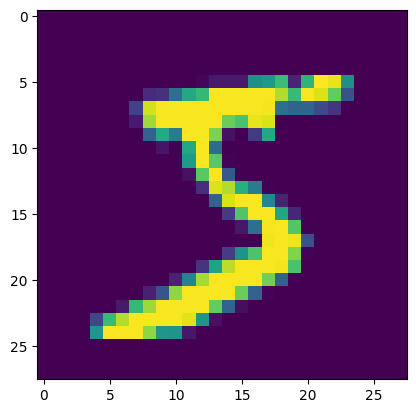

In [23]:
print(type([pairTrain[:, 0], pairTrain[:, 1]]))
print(type(pairTrain[:, 0]))

plt.imshow(pairTrain[1][0])

In [17]:
# compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])
# train the model
print("[INFO] training model...")
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training model...
Epoch 1/100
  28/1875 [..............................] - ETA: 1:38 - loss: 2.8051 - accuracy: 0.5084

KeyboardInterrupt: 

In [ ]:
image1 = np.expand_dims(testX[0], 0)
image2 = np.expand_dims(testX[0], 0)

model.predict([image1, image2])


In [ ]:
model.save('/home/irizqy/ml_ws/bangkit-ws/src/logo-detector/im_similar')

In [ ]:
model = tf.keras.models.load_model('/home/irizqy/ml_ws/bangkit-ws/src/logo-detector/im_similar/')

In [ ]:
model.summary()

In [ ]:
from PIL import Image, ImageOps

im1 = Image.open('/home/irizqy/ml_ws/bangkit-ws/src/ops/cropped-logo.jpg').resize((28, 28))
im1 = ImageOps.grayscale(im1)
im1 = np.asarray(im1)

im2 = Image.open('/home/irizqy/Downloads/tugu.jpeg').resize((28, 28))
im2 = ImageOps.grayscale(im2)
im2 = np.asarray(im2)

In [ ]:
image1 = np.expand_dims(im1, 0)
image2 = np.expand_dims(im2, 0)
model.predict((image1, image2))